### Construct Dataset with Lag Features and Target

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import talib as ta
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


In [20]:
# Define the ticker symbol and date range
ticker_symbol = "MSFT"
start_date = "2000-01-01"
end_date = datetime.today().strftime('%Y-%m-%d')  # Format today's date as a string

# Download historical data for the ticker
df = yf.download(ticker_symbol, start=start_date, end=end_date, interval='1d')


[*********************100%%**********************]  1 of 1 completed


In [21]:
import pandas as pd
import talib as ta

# Example: Replace with your actual DataFrame
# df = pd.read_csv('your_data.csv') 

# Calculate technical indicators
# MACD
df['macd'], df['macdSignal'], df['macdHist'] = ta.MACD(df['Close'], fastperiod=12, slowperiod=26, signalperiod=9)
# RSI
df['rsi'] = ta.RSI(df['Close'], timeperiod=14)
# Bollinger Bands
df['upper_band'], df['middle_band'], df['lower_band'] = ta.BBANDS(df['Close'], timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
# Simple Moving Averages
df['sma200'] = ta.SMA(df['Close'], timeperiod=200)
df['sma100'] = ta.SMA(df['Close'], timeperiod=100)
df['sma50'] = ta.SMA(df['Close'], timeperiod=50)
# Exponential Moving Averages
df['ema12'] = ta.EMA(df['Close'], timeperiod=12)
df['ema26'] = ta.EMA(df['Close'], timeperiod=26)
df['ema50'] = ta.EMA(df['Close'], timeperiod=50)
# Stochastic Oscillator
df['slowk'], df['slowd'] = ta.STOCH(df['High'], df['Low'], df['Close'], fastk_period=14, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
# Volume
df['volume'] = df['Volume']
# Average True Range
df['atr'] = ta.ATR(df['High'], df['Low'], df['Close'], timeperiod=14)
# Average Directional Movement Index
df['adx'] = ta.ADX(df['High'], df['Low'], df['Close'], timeperiod=14)
# Parabolic SAR
df['parabolic_sar'] = ta.SAR(df['High'], df['Low'], acceleration=0.02, maximum=0.2)
# Williams %R
df['williams_r'] = ta.WILLR(df['High'], df['Low'], df['Close'], timeperiod=14)
# Commodity Channel Index
df['cci'] = ta.CCI(df['High'], df['Low'], df['Close'], timeperiod=14)


In [22]:

# Rolling statistics
rolling_windows = [7, 14, 21, 30]
for window in rolling_windows:
    df[f'close_rolling_mean_{window}'] = df['Close'].rolling(window=window).mean()
    df[f'close_rolling_std_{window}'] = df['Close'].rolling(window=window).std()

# Rate of Change for Close prices
df['close_roc'] = df['Close'].pct_change(periods=1)

# Expanded list of features to include for lagging
features_to_lag = ['macd', 'rsi', 'upper_band', 'middle_band', 'lower_band', 
                   'sma200', 'sma100', 'sma50', 'ema12', 'ema26', 'ema50', 
                   'slowk', 'slowd', 'volume', 'atr', 'adx', 'parabolic_sar', 
                   'williams_r', 'cci', 'close_roc'] + \
                  [f'close_rolling_mean_{window}' for window in rolling_windows] + \
                  [f'close_rolling_std_{window}' for window in rolling_windows]

# Add more lag intervals
extended_intervals = [1, 3, 7, 14, 21, 30, 45, 60]

# Creating lag features for all specified indicators
for col in features_to_lag:
    for interval in extended_intervals:
        df[f'{col}_lag{interval}'] = df[col].shift(interval)

# The DataFrame 'df' now includes the original data, technical indicators, and their lagged features


/var/folders/gb/r39h9wdn1gz3p4_y9bdflk380000gn/T/ipykernel_6368/3249340835.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_lag{interval}'] = df[col].shift(interval)
/var/folders/gb/r39h9wdn1gz3p4_y9bdflk380000gn/T/ipykernel_6368/3249340835.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_lag{interval}'] = df[col].shift(interval)
/var/folders/gb/r39h9wdn1gz3p4_y9bdflk380000gn/T/ipykernel_6368/3249340835.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling

In [23]:
# Add more lag intervals
extended_intervals = [1, 3, 7, 14, 21, 30, 45, 60]

# Rolling statistics
rolling_windows = [7, 14, 21, 30]
for window in rolling_windows:
    df[f'close_rolling_mean_{window}'] = df['Close'].rolling(window=window).mean()
    df[f'close_rolling_std_{window}'] = df['Close'].rolling(window=window).std()

# Rate of Change for Close prices
df['close_roc'] = df['Close'].pct_change(periods=1)

# Additional technical indicators
df['cci'] = ta.CCI(df['High'], df['Low'], df['Close'], timeperiod=14)

# Creating lag features for all
features_to_lag = ['macd', 'rsi', 'upper_band', 'middle_band', 'lower_band', 
                   'sma200', 'sma50', 'ema12', 'ema26', 'slowk', 'slowd', 
                   'volume', 'atr', 'adx', 'close_roc', 'cci'] + [f'close_rolling_mean_{window}' for window in rolling_windows] + [f'close_rolling_std_{window}' for window in rolling_windows]

for col in features_to_lag:
    for interval in extended_intervals:
        df[f'{col}_lag{interval}'] = df[col].shift(interval)

In [24]:

# Construct the target column
df['pct_change'] = df['Close'].pct_change(periods=5)
conditions = [
    (df['pct_change'] >= 0.02),
    (df['pct_change'] <= -0.02)
]
choices = [0, 1]
df['target'] = np.select(conditions, choices, default=2)
df.drop(columns=['pct_change'], inplace=True)


/var/folders/gb/r39h9wdn1gz3p4_y9bdflk380000gn/T/ipykernel_6368/1672189396.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['pct_change'] = df['Close'].pct_change(periods=5)
/var/folders/gb/r39h9wdn1gz3p4_y9bdflk380000gn/T/ipykernel_6368/1672189396.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['target'] = np.select(conditions, choices, default=2)


In [25]:

# Clean the DataFrame by dropping NaN values and the 'Date' index if it exists
df.reset_index(drop=True, inplace=True)
df.dropna(inplace=True)


In [26]:
df = df.copy()

In [27]:

# The final DataFrame is ready for use
df.head()


,Open,High,Low,Close,Adj Close,Volume,macd,macdSignal,macdHist,rsi,...,close_rolling_std_21_lag60,close_rolling_std_30_lag1,close_rolling_std_30_lag3,close_rolling_std_30_lag7,close_rolling_std_30_lag14,close_rolling_std_30_lag21,close_rolling_std_30_lag30,close_rolling_std_30_lag45,close_rolling_std_30_lag60,target
259,26.50000,27.87500,26.15625,27.50000,17.048998,101854800,-0.753451,-1.549831,0.796380,57.113847,...,2.151087,3.312477,4.065526,4.692012,4.220042,2.860937,2.516121,3.106186,2.914476,0
260,27.43750,27.50000,26.25000,26.75000,16.584028,73712000,-0.558458,-1.351556,0.793098,53.658692,...,2.264755,3.003174,3.736240,4.562048,4.440562,2.912766,2.017393,3.235074,2.966006,0
261,26.68750,26.75000,25.56250,26.28125,16.293421,68462400,-0.436715,-1.168588,0.731873,51.559281,...,2.215019,2.720511,3.312477,4.444345,4.497181,2.977700,1.690680,3.332885,2.963810,0
262,26.81250,27.43750,26.28125,26.46875,16.409670,72844200,-0.321398,-0.999150,0.677752,52.362167,...,2.136812,2.657625,3.003174,4.277670,4.574455,3.057563,1.888220,3.453969,2.821083,0
263,26.84375,28.09375,26.31250,27.75000,17.203993,109788800,-0.125179,-0.824356,0.699177,57.540987,...,2.179613,2.608973,2.720511,4.065526,4.649071,3.298477,2.114887,3.497015,2.727051,0


In [28]:
# Assuming 'df' is your DataFrame and 'target' is your target column
unique_target_counts = df['target'].value_counts()
print(unique_target_counts)


target
2    2912
0    1613
1    1258
Name: count, dtype: int64


In [29]:

# Assume df is your cleaned DataFrame from previous steps
features = df.drop('target', axis=1)  # Exclude the target variable
targets = df['target']  # Only the target variable

# Perform a train-validation-test split (70-15-15)
X_train, X_temp, y_train, y_temp = train_test_split(features, targets, test_size=0.30, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit on training data and transform training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform validation and test data (do not fit on validation/test data to prevent data leakage)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Now X_train_scaled, X_val_scaled, and X_test_scaled have scaled features
# y_train, y_val, and y_test remain unchanged as the target variables


In [30]:
print(features.columns.to_list())

['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'macd', 'macdSignal', 'macdHist', 'rsi', 'upper_band', 'middle_band', 'lower_band', 'sma200', 'sma100', 'sma50', 'ema12', 'ema26', 'ema50', 'slowk', 'slowd', 'volume', 'atr', 'adx', 'parabolic_sar', 'williams_r', 'cci', 'close_rolling_mean_7', 'close_rolling_std_7', 'close_rolling_mean_14', 'close_rolling_std_14', 'close_rolling_mean_21', 'close_rolling_std_21', 'close_rolling_mean_30', 'close_rolling_std_30', 'close_roc', 'macd_lag1', 'macd_lag3', 'macd_lag7', 'macd_lag14', 'macd_lag21', 'macd_lag30', 'macd_lag45', 'macd_lag60', 'rsi_lag1', 'rsi_lag3', 'rsi_lag7', 'rsi_lag14', 'rsi_lag21', 'rsi_lag30', 'rsi_lag45', 'rsi_lag60', 'upper_band_lag1', 'upper_band_lag3', 'upper_band_lag7', 'upper_band_lag14', 'upper_band_lag21', 'upper_band_lag30', 'upper_band_lag45', 'upper_band_lag60', 'middle_band_lag1', 'middle_band_lag3', 'middle_band_lag7', 'middle_band_lag14', 'middle_band_lag21', 'middle_band_lag30', 'middle_band_lag45', 'middl

### Training

In [31]:
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.utils.class_weight import compute_class_weight


In [32]:
# #Class Balancing
# #TODO: decide whether want to balance completely, or weight buy, sell, hold differently

# #manual class balancing
# # custom_class_weights = {0: 1.0, 1: 1, 2: 1.5}

# # Assuming X_train_scaled, y_train, X_val_scaled, y_val are your data

# # Calculate class weights for training set
# # class_weights = compute_class_weight(class_weight=custom_class_weights, classes=np.unique(y_train), y=y_train)
# class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)

# # Assign weights to each sample in the training set
# sample_weights = np.array([class_weights[i] for i in y_train])


In [33]:

# Initialize the XGBoost classifier for multi-class classification
model = xgb.XGBClassifier(objective='multi:softprob', eval_metric='mlogloss', num_class=3, use_label_encoder=False)

# Fit the model on the training data with sample weights
# model.fit(X_train_scaled, y_train, sample_weight=sample_weights)

#Train without custom weights
model.fit(X_train_scaled, y_train)

# Predict on the validation set
val_predictions = model.predict(X_val_scaled)

# Calculate the accuracy
accuracy = accuracy_score(y_val, val_predictions)
print(f"Validation Accuracy: {accuracy}")

# Additional metrics like F1-score can be calculated as needed


Validation Accuracy: 0.8016147635524798


### Pre Hyperparameter Evaluation and Visualizations

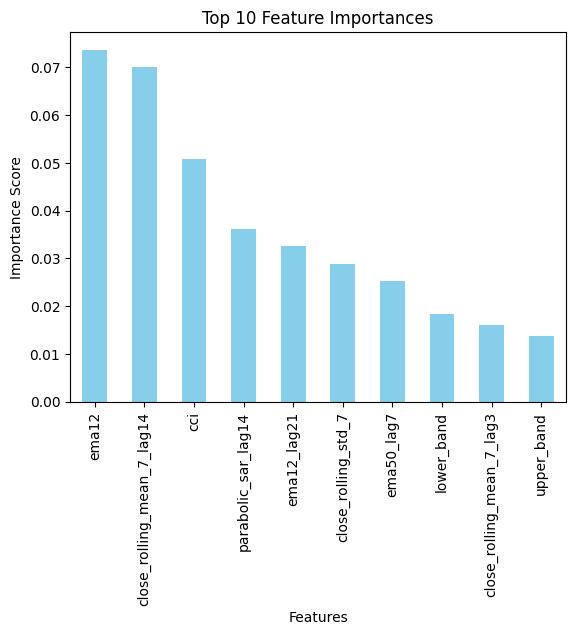

In [34]:
import xgboost as xgb
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'model' is your trained XGBoost model
# and 'features' contains the feature column names

# Get feature importances
feature_importances = model.feature_importances_

# Create a Series for the feature importances
importances = pd.Series(feature_importances, index=features.columns)

# Sort the features by their importance
sorted_importances = importances.sort_values(ascending=False)

# Select the top 5 features
top_5_importances = sorted_importances[:10]

# Plot
top_5_importances.plot(kind='bar', color='skyblue')
plt.title('Top 10 Feature Importances')
plt.ylabel('Importance Score')
plt.xlabel('Features')
plt.show()


Validation Accuracy: 0.8016147635524798
Validation Precision: 0.8060939131241122
Validation Recall: 0.8016147635524798
Validation F1 Score: 0.8019037384774881


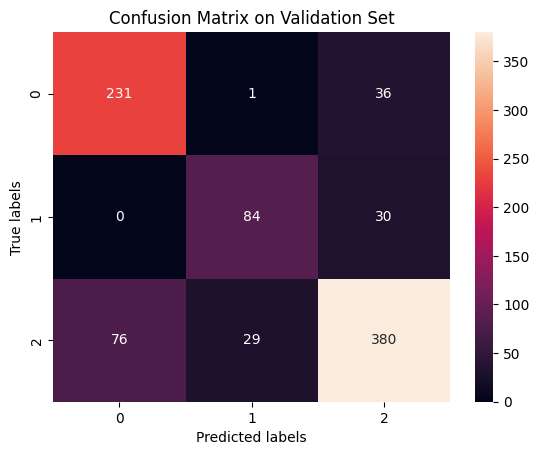

In [35]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming val_predictions are the predictions from your model on the validation set
# and y_val are the true target values

# Calculate evaluation metrics for the validation set
accuracy_val = accuracy_score(y_val, val_predictions)
precision_val = precision_score(y_val, val_predictions, average='weighted')  # Use 'weighted' for imbalanced classes
recall_val = recall_score(y_val, val_predictions, average='weighted')
f1_val = f1_score(y_val, val_predictions, average='weighted')

# Display the metrics
print(f"Validation Accuracy: {accuracy_val}")
print(f"Validation Precision: {precision_val}")
print(f"Validation Recall: {recall_val}")
print(f"Validation F1 Score: {f1_val}")

# Confusion matrix for validation set
conf_matrix_val = confusion_matrix(y_val, val_predictions)

# Visualize the confusion matrix
sns.heatmap(conf_matrix_val, annot=True, fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix on Validation Set')
plt.show()


### Hyperparameter Optimization

In [37]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
import time


# Define your XGBoost classifier
xgb_model = xgb.XGBClassifier(objective='multi:softprob', num_class=3, use_label_encoder=False)

# Define the parameter grid
param_grid = {
    'learning_rate': [.4],
    'n_estimators': [300, 400],
    'max_depth': [2, 4, 6],
    'subsample': [.5, .6, .7],
    'colsample_bytree': [0.5, 0.7, .9],
    'gamma': [0, 0.5]
}

## More thorough hyperparameter search
# param_grid = {
#     'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3],
#     'n_estimators': [50, 100, 150, 200, 250, 300],
#     'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
#     'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
#     'colsample_bytree': [0.3, 0.4, 0.5, 0.6, 0.7],
#     'gamma': [0, 0.05, 0.1, 0.15, 0.2],
#     'min_child_weight': [1, 2, 3, 4, 5],
#     'reg_alpha': [0, 0.1, 0.5, 1, 1.5, 2],  # L1 regularization term
#     'reg_lambda': [0, 0.1, 0.5, 1, 1.5, 2]  # L2 regularization term
# }

# Record start time
start_time = time.time()

# Execute the hyperparameter tuning
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=1)
grid_search.fit(X_train_scaled, y_train)

# Record end time
end_time = time.time()

# Calculate execution time
execution_time = end_time - start_time

# Print the execution time
print(f"Hyperparameter tuning took {execution_time:.2f} seconds")

# Print the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# Evaluate on the validation set
best_model = grid_search.best_estimator_
val_predictions = best_model.predict(X_val_scaled)
val_accuracy = accuracy_score(y_val, val_predictions)
print(f"Validation Accuracy: {val_accuracy}")


Fitting 3 folds for each of 108 candidates, totalling 324 fits


/Users/pravinboopathy/opt/anaconda3/envs/finance/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Hyperparameter tuning took 169.88 seconds
Best Parameters: {'colsample_bytree': 0.9, 'gamma': 0.5, 'learning_rate': 0.4, 'max_depth': 6, 'n_estimators': 400, 'subsample': 0.7}
Best Score: 0.8285553999762055
Validation Accuracy: 0.8004613610149942


Best Parameters: {'colsample_bytree': 0.7, 'gamma': 0, 'learning_rate': 0.4, 'max_depth': 4, 'n_estimators': 300, 'subsample': 0.7}

Test Accuracy: 0.7350230414746544
Test Precision: 0.7544500702122189
Test Recall: 0.7350230414746544
Test F1 Score: 0.7208143299712735


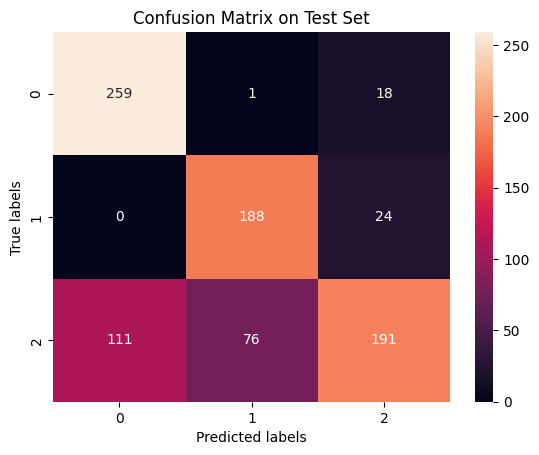

In [42]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming best_grid is your trained model
# X_test_scaled is your scaled test features, and y_test are the true labels

# Generate predictions on the test set
test_predictions = best_model.predict(X_test_scaled)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, test_predictions)
precision = precision_score(y_test, test_predictions, average='weighted')  # Use 'weighted' for imbalanced classes
recall = recall_score(y_test, test_predictions, average='weighted')
f1 = f1_score(y_test, test_predictions, average='weighted')

# Display the metrics
print(f"Test Accuracy: {accuracy}")
print(f"Test Precision: {precision}")
print(f"Test Recall: {recall}")
print(f"Test F1 Score: {f1}")

# Confusion matrix
conf_matrix = confusion_matrix(y_test, test_predictions)

# Visualize the confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix on Test Set')
plt.show()


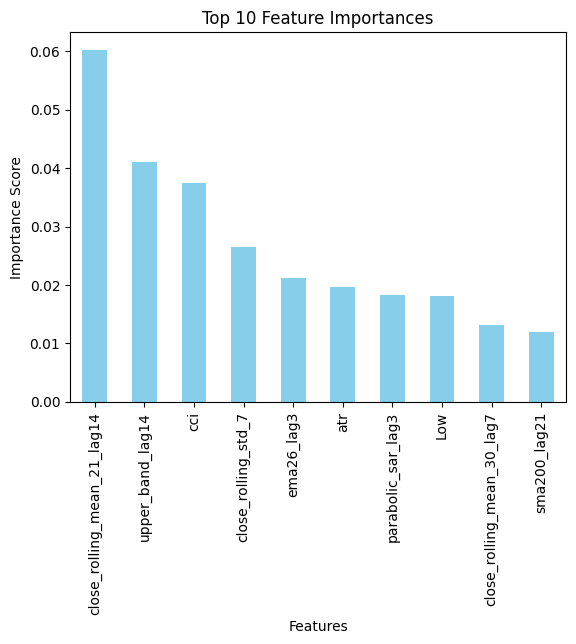

In [43]:
import xgboost as xgb
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'model' is your trained XGBoost model
# and 'features' contains the feature column names

# Get feature importances
feature_importances = best_model.feature_importances_

# Create a Series for the feature importances
importances = pd.Series(feature_importances, index=features.columns)

# Sort the features by their importance
sorted_importances = importances.sort_values(ascending=False)

# Select the top 5 features
top_5_importances = sorted_importances[:10]

# Plot
top_5_importances.plot(kind='bar', color='skyblue')
plt.title('Top 10 Feature Importances')
plt.ylabel('Importance Score')
plt.xlabel('Features')
plt.show()


### Save Dataset and Model

In [45]:
import pickle
from joblib import dump, load
import pandas as pd
from datetime import datetime

# Assuming 'best_model' is your trained model
# 'features' and 'targets' are your datasets

# Generate a unique filename using the current date and time
current_time = datetime.now().strftime("%Y%m%d_%H%M%S")
model_filename = f'20year_wo_date{current_time}.joblib'

# Save the model using joblib
dump(best_model, f'./models/{model_filename}')

# # Save the features and targets datasets using pandas
# features.to_csv('features.csv', index=False)
# targets.to_csv('targets.csv', index=False)


['./models/20year_wo_date20240109_212918.joblib']

In [46]:

# Load the model
loaded_model = load(f'./models/{model_filename}')

# Load the datasets
loaded_features = pd.read_csv('features.csv')
loaded_targets = pd.read_csv('targets.csv')


In [47]:
print(type(test_predictions))
print(test_predictions.shape)

<class 'numpy.ndarray'>
(868,)


### Calculate Returns using Model Signals

In [48]:
#TODO: calculate returns using model signals and benchmark it against other stategy(MACD + SMA?)

In [49]:
best_model = loaded_model

In [50]:
# Extract the test set portion from the original DataFrame
test_df = df.loc[X_test.index]


In [51]:
# Assuming test_df is your DataFrame with 'Close' and 'Predictions'
close_prices_test = test_df['Close'].tolist()
model_predictions_test = test_predictions.tolist()  # 0 for buy, 1 for sell, 2 for hold


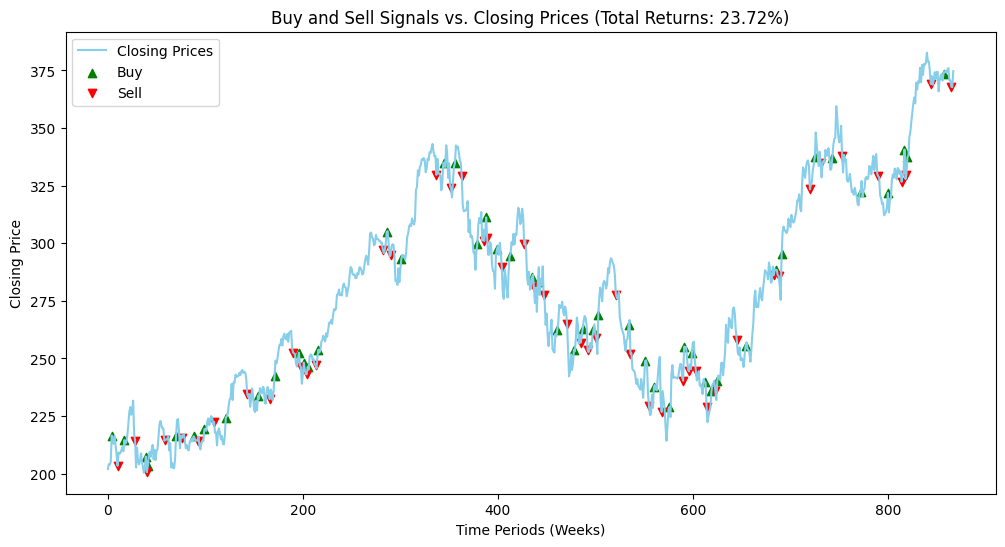

In [52]:
import matplotlib.pyplot as plt

def calculate_return_of_strategy_weekly(close_list, signal_list):
    trade_list = []
    position = 'none'
    buy_price = 0
    buy_sell_points = {'buy': [], 'sell': []}  # To keep track of buy and sell points for plotting

    for i in range(len(close_list)):
        if signal_list[i] == 0 and position == 'none':  # Buy signal
            buy_price = close_list[i]
            position = 'bought'
            trade_list.append(('buy', buy_price))
            buy_sell_points['buy'].append((i, buy_price))  # Record buy point

        elif signal_list[i] == 1 and position == 'bought':  # Sell signal
            sell_price = close_list[i]
            position = 'none'
            trade_list.append(('sell', sell_price))
            buy_sell_points['sell'].append((i, sell_price))  # Record sell point

    total_return = 1
    for i in range(0, len(trade_list), 2):
        if i + 1 < len(trade_list):
            total_return *= (trade_list[i + 1][1] / trade_list[i][1])

    return 100 * (total_return - 1), buy_sell_points

# Assuming test_df is your DataFrame with 'Close' and 'Predictions'
close_prices_test = test_df['Close'].tolist()
model_predictions_test = test_predictions.tolist()  # 0 for buy, 1 for sell, 2 for hold

# Calculate returns and get buy/sell points
returns, buy_sell_points = calculate_return_of_strategy_weekly(close_prices_test, model_predictions_test)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(close_prices_test, label='Closing Prices', color='skyblue')

# Plot buy and sell signals
for buy_point in buy_sell_points['buy']:
    plt.scatter(buy_point[0], buy_point[1], color='green', marker='^', label='Buy' if buy_point == buy_sell_points['buy'][0] else "")

for sell_point in buy_sell_points['sell']:
    plt.scatter(sell_point[0], sell_point[1], color='red', marker='v', label='Sell' if sell_point == buy_sell_points['sell'][0] else "")

plt.title(f"Buy and Sell Signals vs. Closing Prices (Total Returns: {returns:.2f}%)")
plt.xlabel('Time Periods (Weeks)')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

#rn it holds too much when it should sell
#best model so far was the original one(reverted the hyperparameters), it just doesn't perform well on converged markets

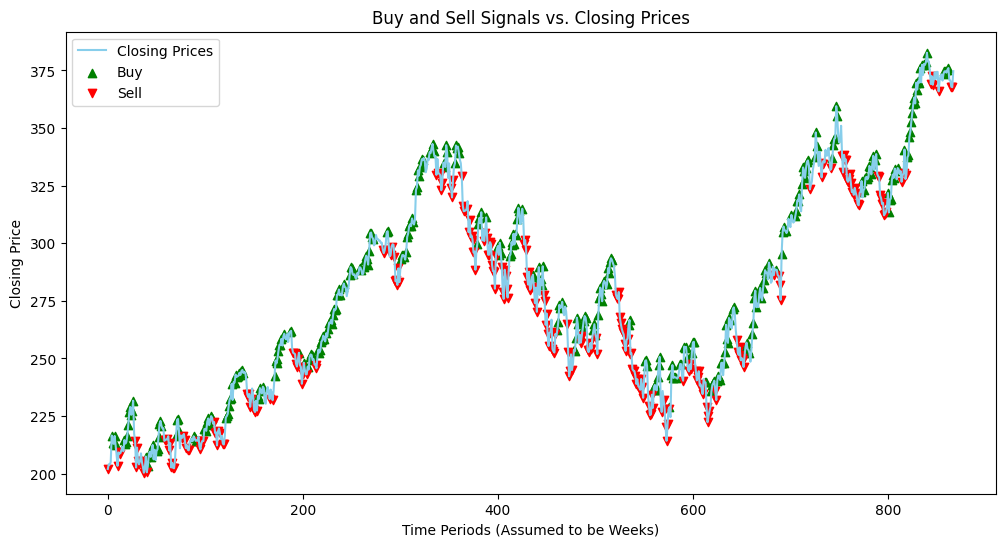

In [53]:
import matplotlib.pyplot as plt

# Assuming test_df is your DataFrame with 'Close' and 'Predictions'
close_prices_test = test_df['Close'].tolist()
model_predictions_test = test_predictions.tolist()  # 0 for buy, 1 for sell, 2 for hold

# Initialize lists for buy and sell points for plotting
buy_points = [(i, close_prices_test[i]) for i in range(len(model_predictions_test)) if model_predictions_test[i] == 0]
sell_points = [(i, close_prices_test[i]) for i in range(len(model_predictions_test)) if model_predictions_test[i] == 1]

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(close_prices_test, label='Closing Prices', color='skyblue')

# Plot buy signals
for buy_point in buy_points:
    plt.scatter(buy_point[0], buy_point[1], color='green', marker='^', label='Buy' if buy_point == buy_points[0] else "")

# Plot sell signals
for sell_point in sell_points:
    plt.scatter(sell_point[0], sell_point[1], color='red', marker='v', label='Sell' if sell_point == sell_points[0] else "")

plt.title("Buy and Sell Signals vs. Closing Prices")
plt.xlabel('Time Periods (Assumed to be Weeks)')
plt.ylabel('Closing Price')
plt.legend()
plt.show()


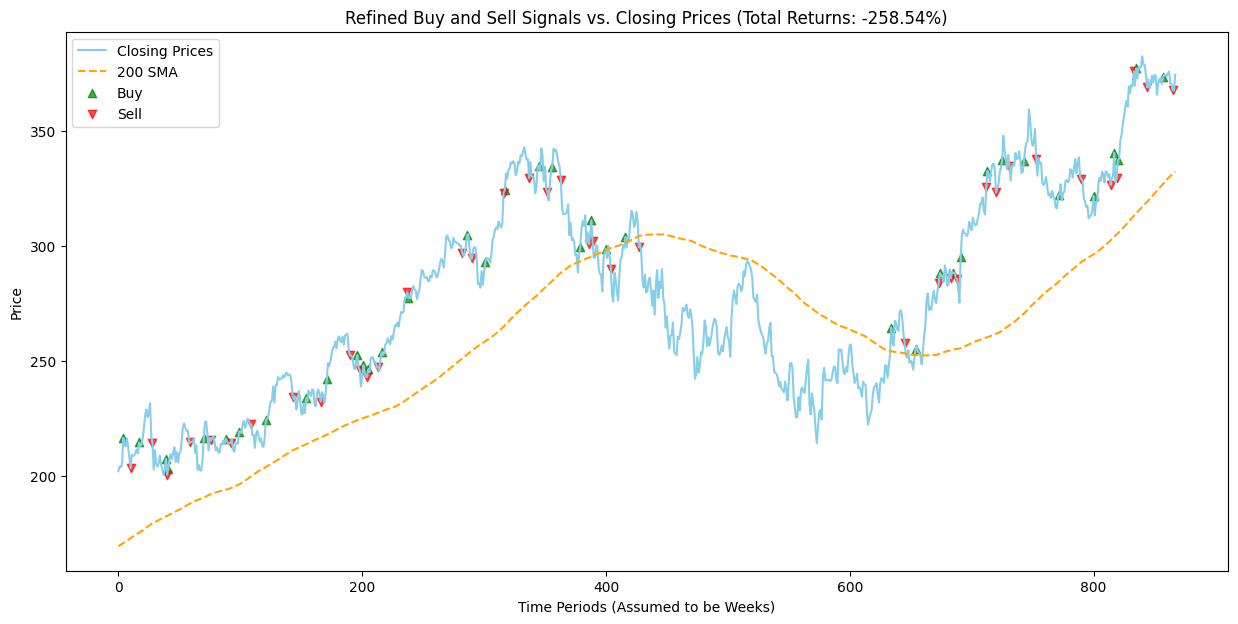

In [54]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_refined_strategy(close_list, signal_list, sma200_list):
    trade_list = []
    position = 'none'
    buy_sell_points = {'buy': [], 'sell': []}
    
    # Define risk management parameters
    stop_loss_percentage = 0.05  # 5% stop loss
    take_profit_percentage = 0.1  # 10% take profit
    risk_factor = 0.02  # risk 2% of portfolio per trade
    
    for i in range(1, len(close_list)):
        if signal_list[i] == 0 and position == 'none' and close_list[i] > sma200_list[i]:  # Buy signal with trend confirmation
            buy_price = close_list[i]
            position = 'bought'
            buy_sell_points['buy'].append((i, buy_price))
            # Set dynamic stop loss and take profit levels
            stop_loss = buy_price * (1 - stop_loss_percentage)
            take_profit = buy_price * (1 + take_profit_percentage)
            # Calculate position size based on risk factor and stop loss
            position_size = risk_factor / stop_loss_percentage

        elif position == 'bought':
            sell_price = close_list[i]
            # Check for stop loss or take profit conditions
            if sell_price <= stop_loss or sell_price >= take_profit:
                position = 'none'
                trade_list.append(('sell', sell_price, position_size))
                buy_sell_points['sell'].append((i, sell_price))
                continue  # Skip further checks and continue with the next period

            # Check for sell signal
            if signal_list[i] == 1:
                position = 'none'
                trade_list.append(('sell', sell_price, position_size))
                buy_sell_points['sell'].append((i, sell_price))

    # Calculate total return considering the position sizes
    total_return = 1
    for trade in trade_list:
        if trade[0] == 'sell':
            # Incorporate position size into return calculation
            trade_return = (trade[1] / buy_price - 1) * trade[2]
            total_return += trade_return

    return 100 * total_return, buy_sell_points

# Assuming test_df is your DataFrame with 'Close', 'Predictions', and 'sma200'
close_prices_test = test_df['Close'].tolist()
model_predictions_test = test_predictions.tolist()  # 0 for buy, 1 for sell, 2 for hold
sma200_test = test_df['sma200'].tolist()  # Your 200-period SMA

# Calculate refined strategy returns and get buy/sell points
returns, buy_sell_points = calculate_refined_strategy(close_prices_test, model_predictions_test, sma200_test)

# Plotting
plt.figure(figsize=(15, 7))
plt.plot(close_prices_test, label='Closing Prices', color='skyblue')
plt.plot(sma200_test, label='200 SMA', color='orange', linestyle='--')

# Plot buy and sell signals
for buy_point in buy_sell_points['buy']:
    plt.scatter(buy_point[0], buy_point[1], color='green', marker='^', alpha=0.7, label='Buy' if buy_point == buy_sell_points['buy'][0] else "")

for sell_point in buy_sell_points['sell']:
    plt.scatter(sell_point[0], sell_point[1], color='red', marker='v', alpha=0.7, label='Sell' if sell_point == buy_sell_points['sell'][0] else "")

plt.title(f"Refined Buy and Sell Signals vs. Closing Prices (Total Returns: {returns:.2f}%)")
plt.xlabel('Time Periods (Assumed to be Weeks)')
plt.ylabel('Price')
plt.legend()
plt.show()


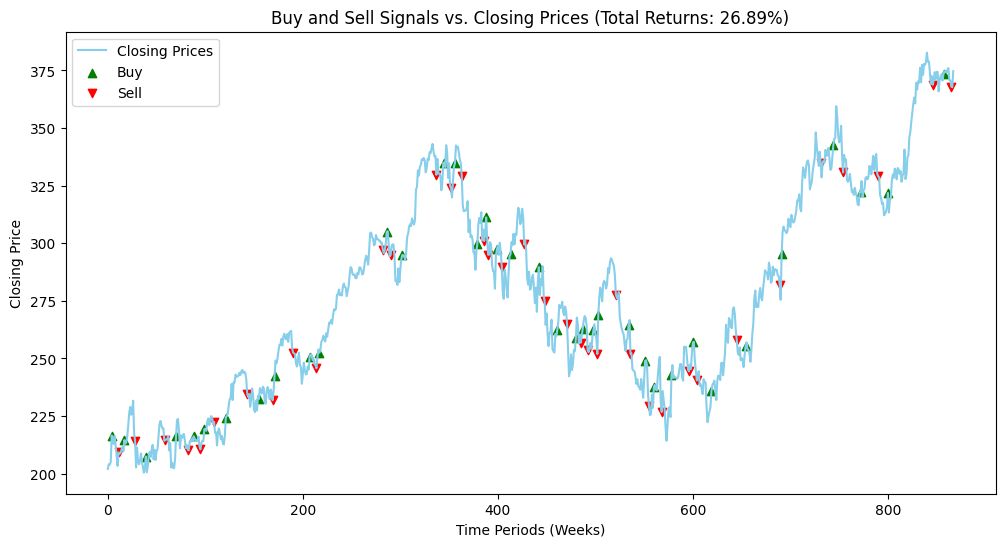

In [55]:
import matplotlib.pyplot as plt

def calculate_return_of_strategy_weekly(close_list, prob_list, buy_threshold, sell_threshold):
    trade_list = []
    position = 'none'
    buy_sell_points = {'buy': [], 'sell': []}

    for i in range(len(close_list)):
        buy_prob, sell_prob = prob_list[i][0], prob_list[i][1]  # Extracting buy and sell probabilities

        if buy_prob >= buy_threshold and position == 'none':  # Buy condition
            buy_price = close_list[i]
            position = 'bought'
            trade_list.append(('buy', buy_price))
            buy_sell_points['buy'].append((i, buy_price))

        elif sell_prob >= sell_threshold and position == 'bought':  # Sell condition
            sell_price = close_list[i]
            position = 'none'
            trade_list.append(('sell', sell_price))
            buy_sell_points['sell'].append((i, sell_price))

    total_return = 1
    for i in range(0, len(trade_list), 2):
        if i + 1 < len(trade_list):
            total_return *= (trade_list[i + 1][1] / trade_list[i][1])

    return 100 * (total_return - 1), buy_sell_points

# Example Usage
# Assuming test_df is your DataFrame with 'Close' and 'model_probabilities_test'
close_prices_test = test_df['Close'].tolist()
model_probabilities_test = best_model.predict_proba(X_test_scaled)# Replace with your model's probability predictions

# Define buy and sell thresholds
buy_threshold = 0.7  # Example value
sell_threshold = 0.7 # Example value

# Calculate returns and get buy/sell points
returns, buy_sell_points = calculate_return_of_strategy_weekly(close_prices_test, model_probabilities_test, buy_threshold, sell_threshold)


# Plotting
plt.figure(figsize=(12, 6))
plt.plot(close_prices_test, label='Closing Prices', color='skyblue')

# Plot buy and sell signals
for buy_point in buy_sell_points['buy']:
    plt.scatter(buy_point[0], buy_point[1], color='green', marker='^', label='Buy' if buy_point == buy_sell_points['buy'][0] else "")

for sell_point in buy_sell_points['sell']:
    plt.scatter(sell_point[0], sell_point[1], color='red', marker='v', label='Sell' if sell_point == buy_sell_points['sell'][0] else "")

plt.title(f"Buy and Sell Signals vs. Closing Prices (Total Returns: {returns:.2f}%)")
plt.xlabel('Time Periods (Weeks)')
plt.ylabel('Closing Price')
plt.legend()
plt.show()



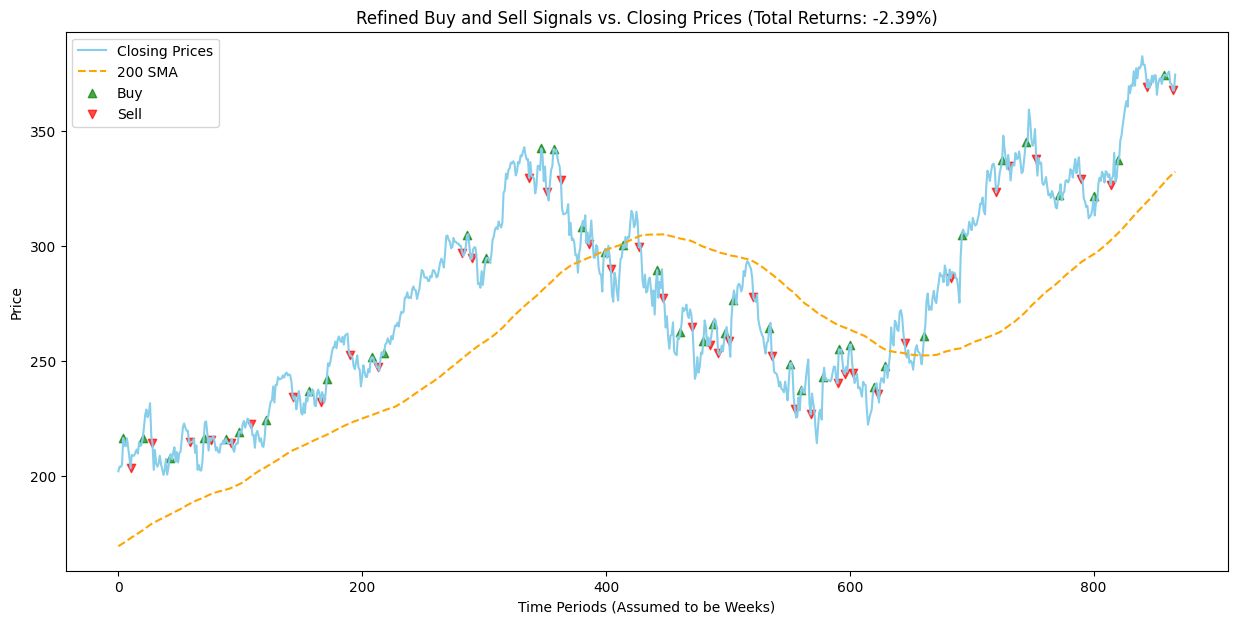

In [58]:
def calculate_return_of_strategy_weekly(close_list, prob_list, signal_list, buy_threshold):
    trade_list = []
    position = 'none'
    buy_sell_points = {'buy': [], 'sell': []}

    for i in range(len(close_list)):
        buy_prob = prob_list[i][0]  # Extracting buy probability

        if buy_prob >= buy_threshold and position == 'none':  # Buy condition
            buy_price = close_list[i]
            position = 'bought'
            trade_list.append(('buy', buy_price))
            buy_sell_points['buy'].append((i, buy_price))  # Record buy point

        elif signal_list[i] == 1 and position == 'bought':  # Sell signal
            sell_price = close_list[i]
            position = 'none'
            trade_list.append(('sell', sell_price))
            buy_sell_points['sell'].append((i, sell_price))  # Record sell point

    total_return = 1
    for i in range(0, len(trade_list), 2):
        if i + 1 < len(trade_list):
            total_return *= (trade_list[i + 1][1] / trade_list[i][1])

    return 100 * (total_return - 1), buy_sell_points

# Example usage
# Assuming test_df is your DataFrame with 'Close', 'model_probabilities_test', and 'Signals'
close_prices_test = test_df['Close'].tolist()
model_probabilities_test = best_model.predict_proba(X_test_scaled)
signal_list_test = test_predictions  # Replace with your signal column

# Define buy threshold
buy_threshold = 0.9  # Example value

# Calculate returns and get buy/sell points
returns, buy_sell_points = calculate_return_of_strategy_weekly(close_prices_test, model_probabilities_test, signal_list_test, buy_threshold)


# Plotting...
plt.figure(figsize=(15, 7))
plt.plot(close_prices_test, label='Closing Prices', color='skyblue')
plt.plot(sma200_test, label='200 SMA', color='orange', linestyle='--')

# Plot buy and sell signals
for buy_point in buy_sell_points['buy']:
    plt.scatter(buy_point[0], buy_point[1], color='green', marker='^', alpha=0.7, label='Buy' if buy_point == buy_sell_points['buy'][0] else "")

for sell_point in buy_sell_points['sell']:
    plt.scatter(sell_point[0], sell_point[1], color='red', marker='v', alpha=0.7, label='Sell' if sell_point == buy_sell_points['sell'][0] else "")

plt.title(f"Refined Buy and Sell Signals vs. Closing Prices (Total Returns: {returns:.2f}%)")
plt.xlabel('Time Periods (Assumed to be Weeks)')
plt.ylabel('Price')
plt.legend()
plt.show()

In [ ]:
#TODO: add rule based strategies and risk mitigation strategies. 

In [ ]:
#Additional TODO: class balance using xgboost.DMatrix?, add more features, add more tickers(as a parameter), further backtrading, parameterize uptrend-downtrend definitions